This is a tutorial in data cleanup using `pandas`. In one of my trainings, I asked the following questions. 


* Download the swimming data from https://en.wikipedia.org/wiki/List_of_world_records_in_swimming
* Combine the frames with the records and clean up the data
* Give a ranking of the swimming speed over different disciplines
* Save the clean data in a file called `swimming_records.feather`
* Give an estimate of how much time a turning point adds to swimming a distance
* Give an estimate of how much time a start adds to adds to swimming 

In this post, I try and answer these. 

In [4]:
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


These swimming records are in HTML tables, and luckily the `pd.read_html` function does work. 

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_world_records_in_swimming"

tables = pd.read_html(url, header = 0, encoding='utf-8')
tables[0].head(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref
0,01 ! 50 m freestyle,20.91,NaN,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",[9][10]
1,02 ! 100 m freestyle,46.91,NaN,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[11][12]
2,03 ! 200 m freestyle,1:42.00,NaN,"Biedermann, PaulPaul Biedermann",Germany,28 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[13][14]
3,04 ! 400 m freestyle,3:40.07,NaN,"Biedermann, PaulPaul Biedermann",Germany,26 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[15][16]
4,05 ! 800 m freestyle,7:32.12,NaN,Zhang Lin,China,29 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[17][18]


There are a few extra tables that we don't need. In addition, the tables refer to long course (50m bath) or short course. I use a `zip` to append that information and then combine all the records into a separate table. 

In [6]:
category = "men", "women", "mixed", "men", "women", "mixed"
course = "long", "long", "long", "short", "short", "short"

record_tables = [t for t in tables if "Event" in t.columns]
len(record_tables)

6

In [7]:
ts = [t.assign(category = c, course = i) for t, c, i in zip(record_tables, category, course)]
raw = pd.concat(ts).reset_index(drop=True)
raw.sample(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref,category,course
26,07 ! 50 m backstroke,27.06,NaN,Zhao Jing,China,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[51][52],women,long
59,18 ! 400 m individual medley,3:55.50,NaN,"Lochte, RyanRyan Lochte",United States,16 December 2010,World Championships,"United Arab Emirates, Dubai ! Dubai, United Ar...",[86],men,short
15,16 ! 200 m individual medley,1:54.00,NaN,"Lochte, RyanRyan Lochte",United States,28 July 2011,World Championships,"China, Shanghai ! Shanghai, China",[34][35],men,long
42,01 ! 50 m freestyle,20.26,NaN,"Manaudou, FlorentFlorent Manaudou",France,5 December 2014,World Championships,"Qatar, Doha ! Doha, Qatar",[69],men,short
90,22.1 ! 4×50 m medley relay,1:43.27,NaN,(26.12) Alexandra Margaret de Loof (28.78) Li...,United States,7 December 2016,World Championships,"Canada, Windsor ! Windsor, Canada",[116],women,short


First things first, I like to work with column names without spaces. There are two columns that are not useful to us, so I drop them immediately. 

In [8]:
raw.shape

(95, 11)

In [9]:
raw.rename(columns = lambda x: x.lower().replace(' ', ''), inplace = True)
raw.drop(['ref', 'unnamed:2'], axis = 1, inplace = True, errors='ignore')
raw.head(2)

,event,time,name,nationality,date,meet,location,category,course
0,01 ! 50 m freestyle,20.91,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",men,long
1,02 ! 100 m freestyle,46.91,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",men,long


The data has a lot of challenging parsing problems. In this post, I use regexes to solve most of those. There are non-breaking spaces, as you cannot see in the table, but it does show if you print separate values as below. There is also a weird `x` character, that you might mistake for an 'x'. I just copied it into the regex formula. 

In [10]:
raw.event.values[0], raw.event.values[25], raw.event.values[17]

('01 ! 50\xa0m freestyle',
 '06 ! 1500\xa0m freestyle',
 '18 ! 4×100\xa0m freestyle relay')

In [35]:
parsed_events = raw.event.str.replace(u'\xa0', ' ').str.extract('[\d\.]+ ! (?:(?P<team_size>4)×)?(?P<distance>\d{2,4}) m (?P<swimstyle>[a-z ]+)', expand = True)
parsed_events[parsed_events.swimstyle.isnull()]

,team_size,distance,swimstyle


In [36]:
parsed_events["team_size"] = parsed_events.team_size.fillna(1).astype(int)
parsed_events.distance = parsed_events.distance.astype(int) * parsed_events.team_size

parsed_events.assign(original = raw.event).sample(5)

,team_size,distance,swimstyle,original
44,1,200,freestyle,03 ! 200 m freestyle
9,1,50,breaststroke,10 ! 50 m breaststroke
55,1,100,butterfly,14 ! 100 m butterfly
24,1,800,freestyle,05 ! 800 m freestyle
49,1,100,backstroke,08 ! 100 m backstroke


Next up are the times. It is possible to tackle these with `strftime` of some sort, but since the format is flexible, and I'm doing regexes already, let's use those again. 

In [37]:
parsed_times = raw.time.str.extract("(?P<m>\d{1,2})?:?(?P<s>\d{2})\.(?P<ms>\d{2})", expand = True)
time_seconds = parsed_times.m.astype(float).fillna(0) * 60 + parsed_times.s.astype(float) + parsed_times.ms.astype(float) / 100
raw.assign(time_seconds = time_seconds)[["event", "time_seconds"]].sample(10)

,event,time_seconds
11,12 ! 200 m breaststroke,126.67
8,09 ! 200 m backstroke,111.92
14,15 ! 200 m butterfly,111.51
10,11 ! 100 m breaststroke,57.13
89,21 ! 4×200 m freestyle relay,452.85
84,17 ! 200 m individual medley,121.86
33,14 ! 100 m butterfly,55.48
81,14 ! 100 m butterfly,54.61
76,11.1 ! 100 m breaststroke,62.36
82,15 ! 200 m butterfly,119.61


## Splitting doubled name and location

The record holder names come out of the `html` in an interesting way. The `pd.read_html` function includes the title of the cell, which is the same name, in different order. Instead of splitting the strings on half their length plus one, I use a very explicit backref operator to make sure my assumptions on these data fields are correct. 

In [38]:
raw.name.values[0], raw.name.values[10]

('Cielo, CésarCésar Cielo', 'Peaty, AdamAdam Peaty')

In [39]:
## Two patterns. One works for most
## But names like Sun Yang are not repeated
## Maybe because it's a chinese character in the html that is ommitted by the parser?
parsed_names = raw.name.str.extract(r"(?P<last_name>[\w ]+), (?P<first_name>[\S ]+)\2 \1", expand = True)
parsed_names_simple = raw.name.str.extract(r"^(?P<last_name>[\w]+) (?P<first_name>[\w ]+)$", expand = True)

q = parsed_names.first_name.isnull() & parsed_names_simple.first_name.notnull()
parsed_names.loc[q] = parsed_names_simple.loc[q]

parsed_names.assign(original = raw.name).sample(10)

,last_name,first_name,original
72,Medeiros,Etiene,"Medeiros, EtieneEtiene Medeiros"
59,Lochte,Ryan,"Lochte, RyanRyan Lochte"
46,Hackett,Grant,"Hackett, GrantGrant Hackett"
77,Atkinson,Alia,"Atkinson, AliaAlia Atkinson"
89,NaN,NaN,(1:54.73) Inge Dekker (1:51.22) Femke Heemske...
29,King,Lilly,"King, LillyLilly King"
24,Ledecky,Katie,"Ledecky, KatieKatie Ledecky"
31,Pedersen,Rikke Møller,"Pedersen, Rikke MøllerRikke Møller Pedersen"
14,Phelps,Michael,"Phelps, MichaelMichael Phelps"
56,le Clos,Chad,"le Clos, ChadChad le Clos"


These names look correct. For the teams, the medley records, I leave the names blank. Next up are the location fields. 

In [40]:
raw.location.values[0], raw.location.values[17]

('Brazil, São Paulo ! São Paulo, Brazil', 'China, Beijing ! Beijing, China')

In [41]:
parsed_locations = raw.location.str.extract(r'(?P<country>[\w ]+), (?P<city>[\w ]+) ! \2, \1', expand = True)
parsed_locations.assign(original = raw.location).sample(5)

,country,city,original
46,Australia,Melbourne,"Australia, Melbourne ! Melbourne, Australia"
52,Germany,Berlin,"Germany, Berlin ! Berlin, Germany"
86,Denmark,Copenhagen,"Denmark, Copenhagen ! Copenhagen, Denmark"
72,Qatar,Doha,"Qatar, Doha ! Doha, Qatar"
55,Canada,Windsor,"Canada, Windsor ! Windsor, Canada"


In [42]:
## check whether the parsing succeeded for all the locations
parsed_locations[parsed_locations.country.isnull()]

,country,city


We have all the separate parts of the dataset and assemble them into a `pd.DataFrame` called `events. 

In [43]:
events = parsed_events.join(
    time_seconds.rename("time")
).join(
    pd.to_datetime(raw.date)
).join(parsed_locations).join(parsed_names).join(
    raw[["course", "category", "nationality", "meet"]]
)

view = events.sample(10)
view

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet
20,1,50,freestyle,23.67,2017-07-29,Hungary,Budapest,Sjöström,Sarah,long,women,Sweden,World Championships
11,1,200,breaststroke,126.67,2017-01-29,Japan,Tokyo,Watanabe,Ippei,long,men,Japan,Kosuke Kitajima Cup
56,1,200,butterfly,108.56,2013-11-05,Singapore,Singapore,le Clos,Chad,short,men,South Africa,World Cup
68,1,200,freestyle,110.43,2017-08-12,Netherlands,Eindhoven,Sjöström,Sarah,short,women,Sweden,World Cup
90,4,200,medley relay,103.27,2016-12-07,Canada,Windsor,NaN,NaN,short,women,United States,World Championships
13,1,100,butterfly,49.82,2009-08-01,Italy,Rome,Phelps,Michael,long,men,United States,World Championships
63,4,800,freestyle relay,409.04,2010-12-16,United Arab Emirates,Dubai,NaN,NaN,short,men,Russia,World Championships
51,1,50,breaststroke,25.25,2009-11-14,Germany,Berlin,van der Burgh,Cameron,short,men,South Africa,World Cup
87,4,200,freestyle relay,93.25,2009-12-11,Turkey,Istanbul,NaN,NaN,short,women,Netherlands,European Championships
85,1,400,individual medley,258.94,2017-08-12,Netherlands,Eindhoven,Belmonte Garcia,Mireia,short,women,Spain,World Cup


In [44]:
events.dtypes

team_size               int64
distance                int64
swimstyle              object
time                  float64
date           datetime64[ns]
country                object
city                   object
last_name              object
first_name             object
course                 object
category               object
nationality            object
meet                   object
dtype: object

This looks fine. I'd like to use the `categorical` type in `pandas`, but it actually gives me some problems here, see https://github.com/pandas-dev/pandas/issues/19136 for example. Let's make some plots and the ranking of swimming speeds to check if this data looks allright. 

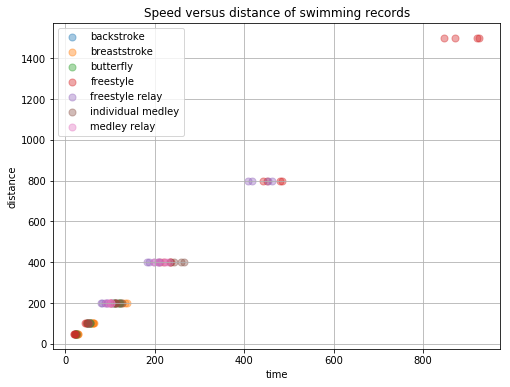

In [46]:
import seaborn as sns

fig = plt.figure(figsize = (8, 6))
ax = fig.subplots(1)
pal = sns.color_palette()

for i, (st, frame) in enumerate(events.groupby(["swimstyle"])):
    frame.plot.scatter(x = 'time', y = 'distance', label = st, ax = ax, color = pal[i], s = 50, alpha = .4);
    
plt.title("Speed versus distance of swimming records")
plt.grid(True);

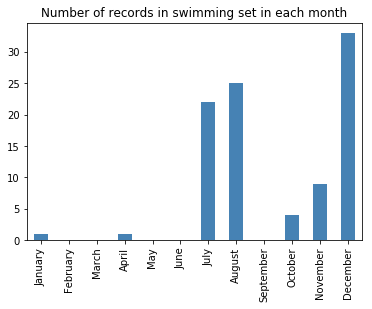

In [49]:
import calendar
month_names = [calendar.month_name[i] for i in range(1, 13)]

events.date.dt.strftime("%B").value_counts().reindex(month_names).plot.bar(color = "steelblue")
plt.title("Number of records in swimming set in each month");

Interesting that most records are broken in December. My first hypothesis would be that this has to do with a recent tournament.

In [52]:
events["speed"] = events.distance / events.time
events.sort_values('speed', ascending = False).head()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
61,4,200,freestyle relay,80.77,2008-12-14,Croatia,Rijeka,NaN,NaN,short,men,France,European Championships,2.476167
42,1,50,freestyle,20.26,2014-12-05,Qatar,Doha,Manaudou,Florent,short,men,France,World Championships,2.467917
60,4,200,freestyle relay,82.60,2014-12-06,Qatar,Doha,NaN,NaN,short,men,Russia,World Championships,2.421308
0,1,50,freestyle,20.91,2009-12-18,Brazil,São Paulo,Cielo,César,long,men,Brazil,Brazilian Championships,2.391200
54,1,50,butterfly,21.80,2009-11-14,Germany,Berlin,Deibler,Steffen,short,men,Germany,World Cup,2.293578


In [53]:
events.sort_values('speed', ascending = False).tail()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
30,1,100,breaststroke,64.13,2017-07-25,Hungary,Budapest,King,Lilly,long,women,United States,World Championships,1.559333
85,1,400,individual medley,258.94,2017-08-12,Netherlands,Eindhoven,Belmonte Garcia,Mireia,short,women,Spain,World Cup,1.544759
36,1,400,individual medley,266.36,2016-08-06,Brazil,Rio de Janeiro,Hosszú,Katinka,long,women,Hungary,Olympic Games,1.501727
79,1,200,breaststroke,134.57,2009-12-18,United Kingdom,Manchester,Soni,Rebecca,short,women,United States,Duel in the Pool,1.486215
31,1,200,breaststroke,139.11,2013-08-01,Spain,Barcelona,Pedersen,Rikke Møller,long,women,Denmark,World Championships,1.437711


The fastest discipline is the 4 times 50 freestyle relay. That's interesting because that would mean that the split times on this have to be faster than the world record, at least for one. Another aspect to keep in mind is that some records are listed twice, I assume because of the records that were broken with the floating suits that came up some time ago, and were banned afterwards.  

The slowest discipline is the breaststroke, that makes sense. Apparently, there is no breaststroke 400m record. Also, from the table below, we can see quite clearly that short course is faster than long course. 

In [58]:
events.loc[events.swimstyle == "breaststroke", ["distance", "swimstyle", "speed", "time", "category", "course"]].sort_values('speed')

,distance,swimstyle,speed,time,category,course
31,200,breaststroke,1.437711,139.11,women,long
79,200,breaststroke,1.486215,134.57,women,short
30,100,breaststroke,1.559333,64.13,women,long
11,200,breaststroke,1.578906,126.67,men,long
76,100,breaststroke,1.603592,62.36,women,short
77,100,breaststroke,1.603592,62.36,women,short
78,100,breaststroke,1.603592,62.36,women,short
53,200,breaststroke,1.660578,120.44,men,short
29,50,breaststroke,1.700680,29.40,women,long
75,50,breaststroke,1.745810,28.64,women,short


In [51]:
events.to_feather("./data/swimming-records.feather")

Now that we have the data in what looks like a clean format, it is time to turn to the two other questions. 

## Part 2: Analysis

* Give an estimate of how much time a turning point adds to swimming a distance
* Give an estimate of how much time a start adds to adds to swimming 

For calculating the extra time a turn adds, I use a pivot table. The idea is that I can only really compare the same distances and swimming styles. 

In [70]:
view = events.pivot_table(index=["distance", "swimstyle", "category"], columns='course', values='time').reset_index()
view.sample(5)

course,distance,swimstyle,category,long,short
16,100,individual medley,men,NaN,50.30
29,200,individual medley,men,114.00,109.63
44,800,freestyle,men,452.12,443.42
28,200,freestyle relay,women,NaN,93.58
13,100,butterfly,women,55.48,54.61


In [71]:
view["additional_turnpoints"] = ((view.distance / 25) - 1) - ((view.distance / 50) - 1)
view["additional_time_per_turn"] = (view.short - view.long) / (view.additional_turnpoints)
view.sample(5)

course,distance,swimstyle,category,long,short,additional_turnpoints,additional_time_per_turn
1,50,backstroke,women,27.06,25.67,1.0,-1.390
9,100,backstroke,women,58.10,55.03,2.0,-1.535
4,50,butterfly,men,22.43,21.80,1.0,-0.630
10,100,breaststroke,men,57.13,55.61,2.0,-0.760
30,200,individual medley,women,126.12,121.86,4.0,-1.065


Instead of averaging this, I will create a visualization that shows the differences in each discipline. 

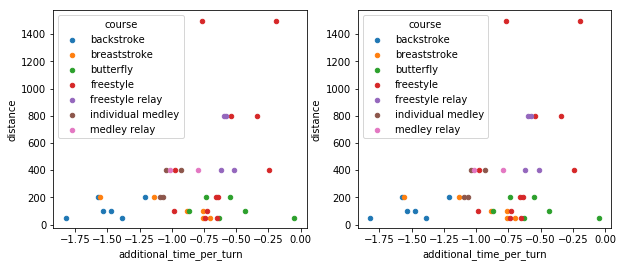

In [75]:
pal = sns.color_palette()

def plot_cat(category, ax):
    for i, (style, frame) in enumerate(view.groupby("swimstyle")):
        frame.plot.scatter(x = "additional_time_per_turn", y = "distance", ax = ax, label = style, c = pal[i]);
    
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

for cat, ax in zip(["women", "men"], axes):
    plot_cat(cat, ax)

It's just a bit painful to fix this in `pandas` / `matplotlib`. I like to use `ggplot` for this, switch to `R`, but for this post I'll give `plotnine` a try.

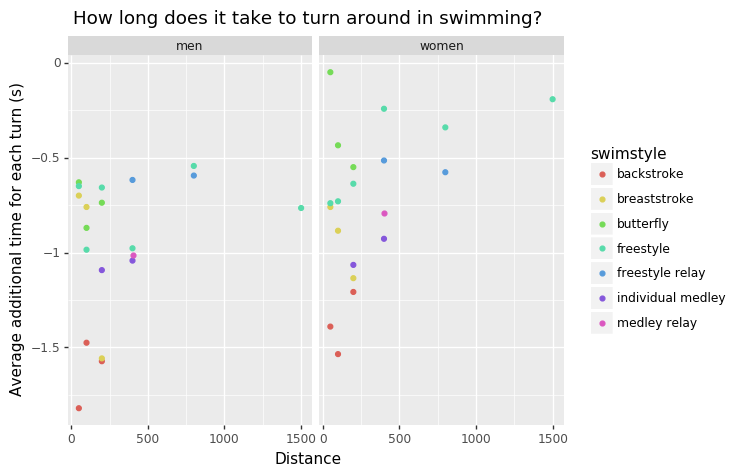

In [116]:
import plotnine as pn

fig = pn.ggplot(view[view.category != "mixed"].dropna()) + \
    pn.geom_point(pn.aes(x = "distance", y = "additional_time_per_turn", color = "swimstyle")) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Distance", 
        y = "Average additional time for each turn (s)",
        title = "How long does it take to turn around in swimming?")
    
fig.draw();

`plotnine` works fine. I don't like the distance on the x axis. Below I've created one with speed, which is also not ideal. But we can see how long a turn takes. 

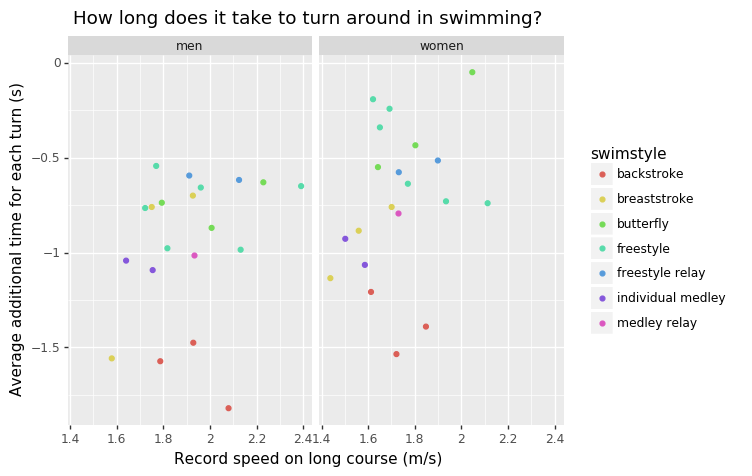

In [117]:
fig = pn.ggplot(view[view.category != "mixed"].dropna().assign(long_speed = view.distance / view.long)) + \
    pn.geom_point(pn.aes(x = "long_speed", y = "additional_time_per_turn", color = "swimstyle")) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Record speed on long course (m/s)", 
        y = "Average additional time for each turn (s)",
        title = "How long does it take to turn around in swimming?")
    
fig.draw();

We can see that a turn doesn't really take time, it's actually quicker than swimming. The difference between long and short course seems larger for backstroke. The turn in the butterfly style isn't too quick, perhaps because it's a tricky technique, or because the butterfly is already quite quick? On longer distances, the advantage of the turns disappears a bit. 

I'll consider this question answered, allthough there is much more to be said. The most important critique that I can come up with here is that it's perhaps not the best idea to answer this question using records. These are weird cases, and with more data, old records or just data from many swimming tournaments, we could produce a much more reliable estimate. 

Now onto the next question; how long does a start take? This is kind of tricky because we cannot really isolate the starts from the data, since each record has exactly one start. You could say 100m equals 2 x 50m without the extra start, but the swimming speeds are also different. I think I'd need some physical model to estimate speed from this data, and then use that in the equation. 

Interesting. Hopefully I can do that some other time. For now, I'll just use the simplified idea. 

In [137]:
view = pd.concat([events.assign(doubled = "real"), events.assign(time = events.time * 2, distance = events.distance * 2, doubled = "hypothetical")])
view = view[["distance", "swimstyle", "doubled", "category", "course", "time"]].copy()
view = view.pivot_table(index=["distance", "swimstyle", "category", "course"], values="time", columns="doubled").dropna().reset_index()
view["difference"] = view.real - view.hypothetical
view.sample(5)

doubled,distance,swimstyle,category,course,hypothetical,real,difference
33,200,individual medley,women,short,113.02,121.86,8.84
3,100,backstroke,women,short,51.34,55.03,3.69
49,800,freestyle,women,short,469.04,479.34,10.30
45,400,medley relay,women,short,205.96,225.20,19.24
41,400,individual medley,men,short,219.26,235.50,16.24


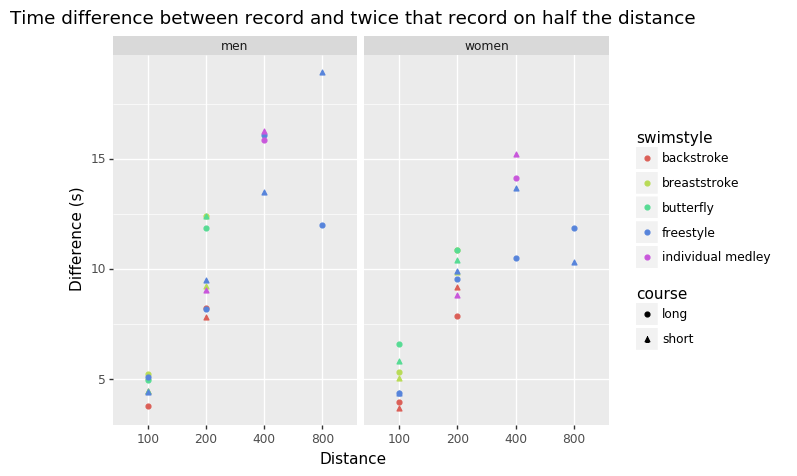

In [150]:
q = (view.category != "mixed") & ~view.swimstyle.str.contains("relay")

fig = pn.ggplot(view[q].dropna()) + \
    pn.geom_point(pn.aes(x = "factor(distance)", y = "difference", color = "swimstyle", shape = "course")) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Distance", 
        y = "Difference (s)",
        title = "Time difference between record and twice that record on half the distance")
    
fig.draw();

Well, the start doesn't save more than a couple of seconds, but it's hard to say more. This difference is for a large part fatigue of the swimmer.